# generic bulk model
<p>from mass balance + fick's</p>
<p>r. darling</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#S=1.62 mg/kg
S=2.2e-4
c_feed = 1/1000
c_proton = 1.1

## reference c*_oxidation and c*_reduction
c_H2_0 = 1
c_proton_0 = 1

z = 1
alpha = 0.5
T = 273.15 + 80
RT = 8.314*T
E_eq = 0.0
#E = np.arange(-0.3,1.1,0.2)
n = 2

a_v = 4e10
L = 15e-6
x = np.arange(0, L+0.5e-6, 0.5e-6)
i_0 = 2e-4
F = 96485
D = 0.77e-5

# concentration with rxn plugged in
def c_cl(i,E):
    b = alpha*z*F/RT*(E[i]-E_eq)
    g = (a_v*i_0) / (c_H2_0*n*F*D)*np.exp(b)
    rt_g = np.sqrt(g)
    om = (c_proton*c_H2_0)/c_proton_0 * np.exp(-2*b)/RT
    return om + (c_feed-om)/(np.exp(-2*rt_g*L)+1)*(np.exp(-2*rt_g*L+rt_g*x)+np.exp(-rt_g*x))
    
def current(c):
    area = np.trapz(c)
    coul = -(1-area)/(n*F)
    return coul

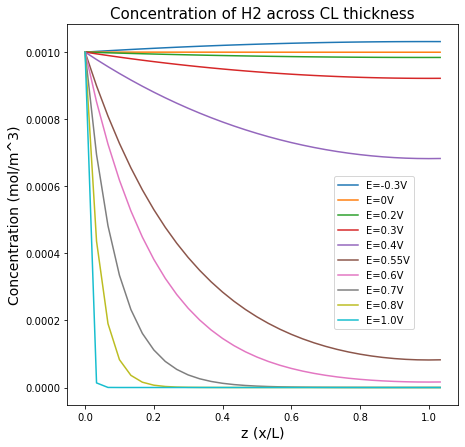

In [2]:
I=[]
E = [-0.3,0,0.2,0.3,0.4,0.55,0.6,0.7,0.8,1.0]

plt.figure(figsize=(7,7))
for i in range(len(E)):
    conc1 = c_cl(i,E)
    plt.plot(x/L, conc1, label=('E=' + str(round(E[i],2)) + 'V'))
    I = np.append(I,current(conc1))

#E=[0.6]
#plt.plot(x/L, c_cl(0), label=(str(round(E[0],2)) + 'V'), color='red')
plt.title('Concentration of H2 across CL thickness', fontsize='15')
plt.ylabel('Concentration (mol/m^3)', fontsize='14')
plt.xlabel('z (x/L)', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
plt.legend(bbox_to_anchor=(0.9,0.4))
plt.show()


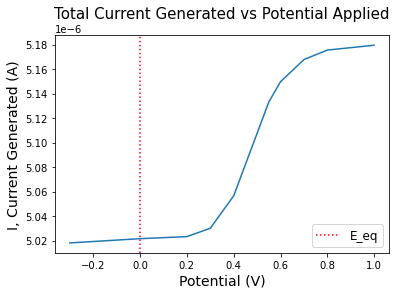

In [3]:
plt.plot(E,-I)
line1 = plt.axvline(0, color='red',linestyle=':',label='E_eq')
#line2 = plt.axvline(0.875, color='orange',linestyle='-',label='I>0 (~0.875V)')
plt.title('Total Current Generated vs Potential Applied', fontsize='15', y=1.05)
plt.ylabel('I, Current Generated (A)', fontsize='14')
plt.xlabel('Potential (V)', fontsize='14')

leg1 = plt.legend(handles=[line1], loc='lower right', fontsize=12)
#plt.gca().add_artist(leg1)
#plt.legend(handles=[line2], loc='lower right', fontsize=12)
plt.show()

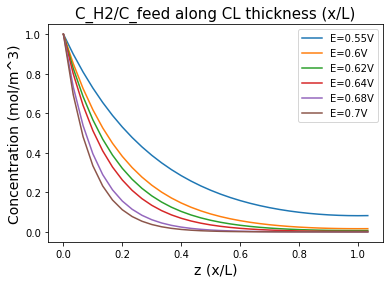

In [4]:
I=[]
#plt.figure(figsize=(7,7))
E1=[0.55,0.6,0.62,0.64,0.68,0.7]
for i in range(len(E1)):
    conc1 = c_cl(i,E1)
    plt.plot(x/L, conc1/c_feed, label=('E=' + str(round(E1[i],2)) + 'V'))
    I = np.append(I,current(conc1))

#E=[0.6]
#plt.plot(x/L, c_cl(0), label=(str(round(E[0],2)) + 'V'), color='red')
plt.title('C_H2/C_feed along CL thickness (x/L)', fontsize='15')
plt.ylabel('Concentration (mol/m^3)', fontsize='14')
plt.xlabel('z (x/L)', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
plt.legend(loc='upper right')
#plt.yscale('log')
plt.show()


---
# film-agglomerate spherical model
based on yoon 2011 (https://sci-hub.se/10.1149/1.3597644)

In [5]:
R_a = 0.1e-6
del_f = 20e-9
R_sph = R_a+del_f

D_agg = 8.45e-10
D_CL = 2.30e-5
#dry ionomer: Df = 104e-8
Df = 0.5e-5
i_0 = 2e-4

eps = 0.4
L_ca = 0.2
A_ca = 40

In [6]:
def constants(E,i,x_cl):
    theta = (i_0*L_ca*A_ca)/((1-eps)*L*c_proton*F)*np.exp(alpha*z*F*(E[i]-E_eq)/RT)
    phi = np.sqrt(theta*R_sph/D_agg)
    omega = D_agg/Df * eps/np.sinh(phi*R_a/R_sph) * (-(R_a/R_sph)*np.sinh(phi*R_a/R_sph) + 
                                      (R_a/R_sph)**2*phi*np.cosh(phi*R_a/R_sph))
    p = (1-eps)*D_agg/(4/3*R_a*D_CL*np.sinh(phi*R_a/R_sph)
               ) * (R_sph/R_a) * ( phi*np.cosh(R_a/R_sph) - (R_sph/R_a)*np.sinh(phi*R_a/R_sph)
                                 ) * eps/(R_sph/R_a*omega - omega + 1)
    rt_p = np.sqrt(abs(p))
    k1 = 1/(1+np.exp(-2*rt_p*L))
    conc_bulk = combined_bulk(x_cl,k1,rt_p)
    c_film_0 = S*conc_bulk / (R_sph/R_a * omega - omega + 1)
    return [theta,phi,omega,rt_p,k1,conc_bulk,c_film_0]

def combined_bulk(x,k1,rt_p):
    return c_feed*((1-k1)*np.exp(rt_p*x) + k1*np.exp(-rt_p*x))

## concentration in agglomerate
def c_agg(zed):
    return (1/zed) * eps*c_film_0 * R_a/R_sph * np.sinh(phi*zed) / np.sinh(phi*R_a/R_sph)

## concentration in film
def c_film(zed):
    return S*conc_bulk + omega*c_film_0*(1-1/zed)


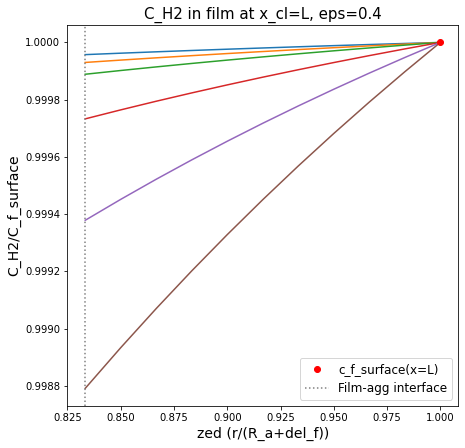

In [16]:
plt.figure(figsize=(7,7))

c_f_surf = S*c_feed
zed_i = np.arange(0.05e-8, R_a, 0.05e-8) / R_sph
zed_o = np.arange(R_a, R_sph+0.1*del_f, 0.1*del_f) / R_sph
x_cl = L

#E = [-0.3,0,0.3,0.5,0.6,0.7,0.8]
E=[0.3,0.35,0.4,0.5,0.6,0.68]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
j=0
for i in range(len(E)):
    if j>len(colors):
        j=0
    [theta, phi, omega, rt_p, k1, conc_bulk, c_film_0] = constants(E,i,x_cl)
    plt.plot(zed_o, c_film(zed_o)/c_f_surf, color=colors[j])
    #plt.plot(zed_i, c_agg(zed_i)/c_f_surf, color=colors[j], label=('E='+str(E[i])))
    j+=1

dot = plt.plot(1,1,'o',color='red',label='c_f_surface(x=L)')
plt.title('C_H2 in film at x_cl=L, eps=0.4', fontsize='15')
plt.ylabel('C_H2/C_f_surface', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
#plt.yscale('log')
plt.xlabel('zed (r/(R_a+del_f))', fontsize='14')
plt.axvline(R_a/R_sph, color='grey', linestyle=':', label='Film-agg interface')

plt.legend(fontsize='12')
#txt = 'Figure 5. Transport through the ionomer film increases with higher overpotential.'
#plt.text(0.5, -0.3, txt, horizontalalignment='center', fontsize=12)
plt.show()

---
# Combined model

$$
A \left[ -D \frac{\partial c_{bulk}}{\partial x} \mid _{x} - \left( -D \frac{\partial c_{bulk}}{\partial x} \right) \mid _{x+dx} \right] = \left( \frac{\text{rxn rate}}{\text{unit CL vol}} \right) A dx
$$

$$
-D \frac{\partial^2 c_{bulk}}{\partial x^2} = \frac{\text{reaction rate}}{\text{unit CL vol}}
$$

$$ \phi _{CL} = \frac{\text{void vol}}{\text{total CL volume}} $$

$$ \Delta V_{CL} (1-\phi_{CL}) = \text{solid vol in $\Delta V$ CL vol} $$

$$ \text{Num. of aggl. } = \frac{\Delta V_{CL} (1-\phi_{CL})}{\frac{4}{3} \pi R_{agg}^3} $$

$$ \text{Consum. per aggl. } = 4 \pi R_{agg}^2 \left[ -D_{agg} \frac{\partial c_{agg}}{\partial r} \right] $$

$$ \frac{\text{reaction rate}}{\text{unit CL vol}} = \left( \frac{\text{# aggl.}}{\text{unit vol}} \right) \left( \frac{\text{consump.}}{\text{aggl.}} \right) $$


$$ -D_{agg} \frac{\partial^2 c_{bulk}}{\partial r^2} = \left( \frac{1-\phi_{CL}}{\frac{4}{3} R_{agg}^3 } \right) \left( 4 \pi R_{agg}^3 \left[ -D_{agg} \frac{\partial c_{agg}}{\partial r} \right] \right) $$

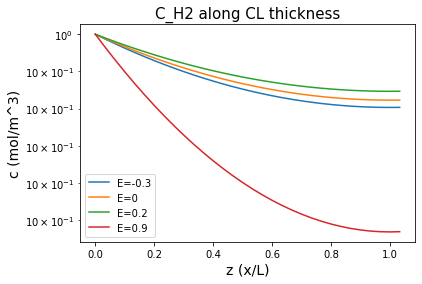

In [8]:
# D_CL: https://escholarship.org/content/qt7kr960nf/qt7kr960nf.pdf
# De: https://sci-hub.se/10.1016/j.ijhydene.2018.07.035
# D_H2mix = 4.9e-5 for r_pore ~ 200nm

j=0
E=[-0.3,0,0.2,0.9]
for i in range(len(E)):
    arr_c_bulk=[]
    for p in range(len(x)):
        [theta, phi, omega, rt_p, k1, conc_bulk, c_film_0] = constants(E,i,x[p])
        arr_c_bulk = np.append(arr_c_bulk, conc_bulk)
    plt.plot(x/L, arr_c_bulk/c_feed, label='E='+str(E[i]))

plt.title('C_H2 along CL thickness', fontsize='15')
plt.ylabel('c (mol/m^3)', fontsize='14')
plt.yscale('log')
plt.xlabel('z (x/L)', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
plt.legend()
plt.show()

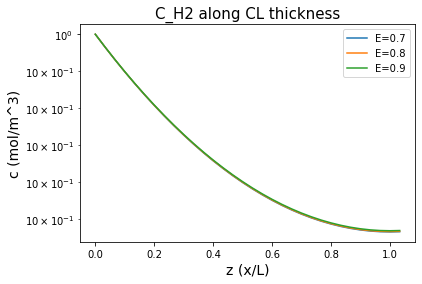

In [9]:
j=0
E=[0.7,0.8,0.9]
for i in range(len(E)):
    arr_c_bulk=[]
    for p in range(len(x)):
        [theta, phi, omega, rt_p, k1, conc_bulk, c_film_0] = constants(E,i,x[p])
        arr_c_bulk = np.append(arr_c_bulk, conc_bulk)
    plt.plot(x/L, arr_c_bulk/c_feed, label='E='+str(E[i]))

plt.title('C_H2 along CL thickness', fontsize='15')
plt.ylabel('c (mol/m^3)', fontsize='14')
plt.yscale('log')
plt.xlabel('z (x/L)', fontsize='14')
#plt.grid(True,which="both", linestyle='--')
plt.legend()
plt.show()